In [2]:
# Basic packages always been used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data scaling
from sklearn.preprocessing import MinMaxScaler

# Function for spilting training & testing data set
from sklearn.model_selection import train_test_split

# Tensorflow sequential models
from tensorflow import keras
from keras import backend as clear
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.optimizers import SGD
from keras.optimizers import Adam

# Functions for evaluation
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import mean_squared_error #MSE,RMSE
from sklearn.metrics import mean_absolute_percentage_error #MAPE

# Note: Some metrics need to be defined manually

In [3]:
# Symmetric Mean Absolute Percentage Error (SMAPE)
def SMAPE_calulate(y_true, y_pred):
    n = len(y_true)
    SMAPE=(100 / n) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
    return SMAPE

# Relative Absolute Error (RAE)
def RAE_calculate(y_true, y_pred):
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    return RAE

# Mean Relative Absolute Error (MRAE)
def MRAE_calculate(y_true, y_pred):
    n=len(y_true)
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    MRAE=RAE/n
    return MRAE

# Median Relative Absolute Error (MdRAE) comparing with benchmark
# Note: By default, the bench value is the mean of actual value
def MdRAE_calculate(y_true, y_pred, bench=None):
    if bench==None:
        bench=np.mean(y_true)
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE,bench
    else:
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE

# Relative Squared Error (RSE) & Root Relative Squared Error (RRSE)
def RSE_calculate(y_true, y_pred, Root=False):
    mse = np.mean((y_true - y_pred)**2)
    denominator = np.var(y_true)
    RSE=mse/denominator

    if Root==True:
        return np.sqrt(RSE)
    else:
        return RSE

In [4]:
#load data(sometimes need to use "/")
#df = pd.read_csv('D:/pythonData/python_demo_data/Rainfall_Forecast.csv')
# Colab
df = pd.read_csv('TSLA.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,2.333333,2.363333,2.314000,2.357333,2.357333,17922000
1,2013-01-03,2.345333,2.363333,2.316667,2.318000,2.318000,11130000
2,2013-01-04,2.320000,2.320000,2.261333,2.293333,2.293333,10110000
3,2013-01-07,2.320000,2.320000,2.260000,2.289333,2.289333,6630000
4,2013-01-08,2.300000,2.300000,2.207333,2.245333,2.245333,19260000
...,...,...,...,...,...,...,...
1254,2017-12-22,21.967333,22.061333,21.654667,21.680000,21.680000,63237000
1255,2017-12-26,21.588667,21.596001,21.105333,21.152666,21.152666,65676000
1256,2017-12-27,21.066668,21.178667,20.716667,20.775999,20.775999,70681500
1257,2017-12-28,20.783333,21.054667,20.636000,21.024000,21.024000,64744500


# 1. Preparations for time-series data

Note: Pandas has a specific data type for time-series data

In [5]:
# 1.1 Convert date
df['Date']=pd.to_datetime(df.iloc[:,0])
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,2.333333,2.363333,2.314000,2.357333,2.357333,17922000
1,2013-01-03,2.345333,2.363333,2.316667,2.318000,2.318000,11130000
2,2013-01-04,2.320000,2.320000,2.261333,2.293333,2.293333,10110000
3,2013-01-07,2.320000,2.320000,2.260000,2.289333,2.289333,6630000
4,2013-01-08,2.300000,2.300000,2.207333,2.245333,2.245333,19260000
...,...,...,...,...,...,...,...
1254,2017-12-22,21.967333,22.061333,21.654667,21.680000,21.680000,63237000
1255,2017-12-26,21.588667,21.596001,21.105333,21.152666,21.152666,65676000
1256,2017-12-27,21.066668,21.178667,20.716667,20.775999,20.775999,70681500
1257,2017-12-28,20.783333,21.054667,20.636000,21.024000,21.024000,64744500


In [6]:
# Date is converted into special data type of pandas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1259 non-null   datetime64[ns]
 1   Open       1259 non-null   float64       
 2   High       1259 non-null   float64       
 3   Low        1259 non-null   float64       
 4   Close      1259 non-null   float64       
 5   Adj Close  1259 non-null   float64       
 6   Volume     1259 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 69.0 KB


In [7]:
df.rename(columns={'Close': 'Y'}, inplace=True)
new_df = df.iloc[:, [0,4]]

# new_df=df.iloc[:,[4,3]].copy()
new_df.head()

,Date,Y
0,2013-01-02,2.357333
1,2013-01-03,2.318000
2,2013-01-04,2.293333
3,2013-01-07,2.289333
4,2013-01-08,2.245333


In [8]:
# View descriptive statistics of target variable
# Pandas will automatically ignore date if the correct data type has been converted
new_df.describe()

,Date,Y
count,1259,1259.000000
mean,2015-07-02 12:47:27.974583040,14.419571
min,2013-01-02 00:00:00,2.194000
25%,2014-04-02 12:00:00,12.578000
50%,2015-07-02 00:00:00,14.638667
75%,2016-09-29 12:00:00,16.866999
max,2017-12-29 00:00:00,25.666668
std,NaN,5.055707


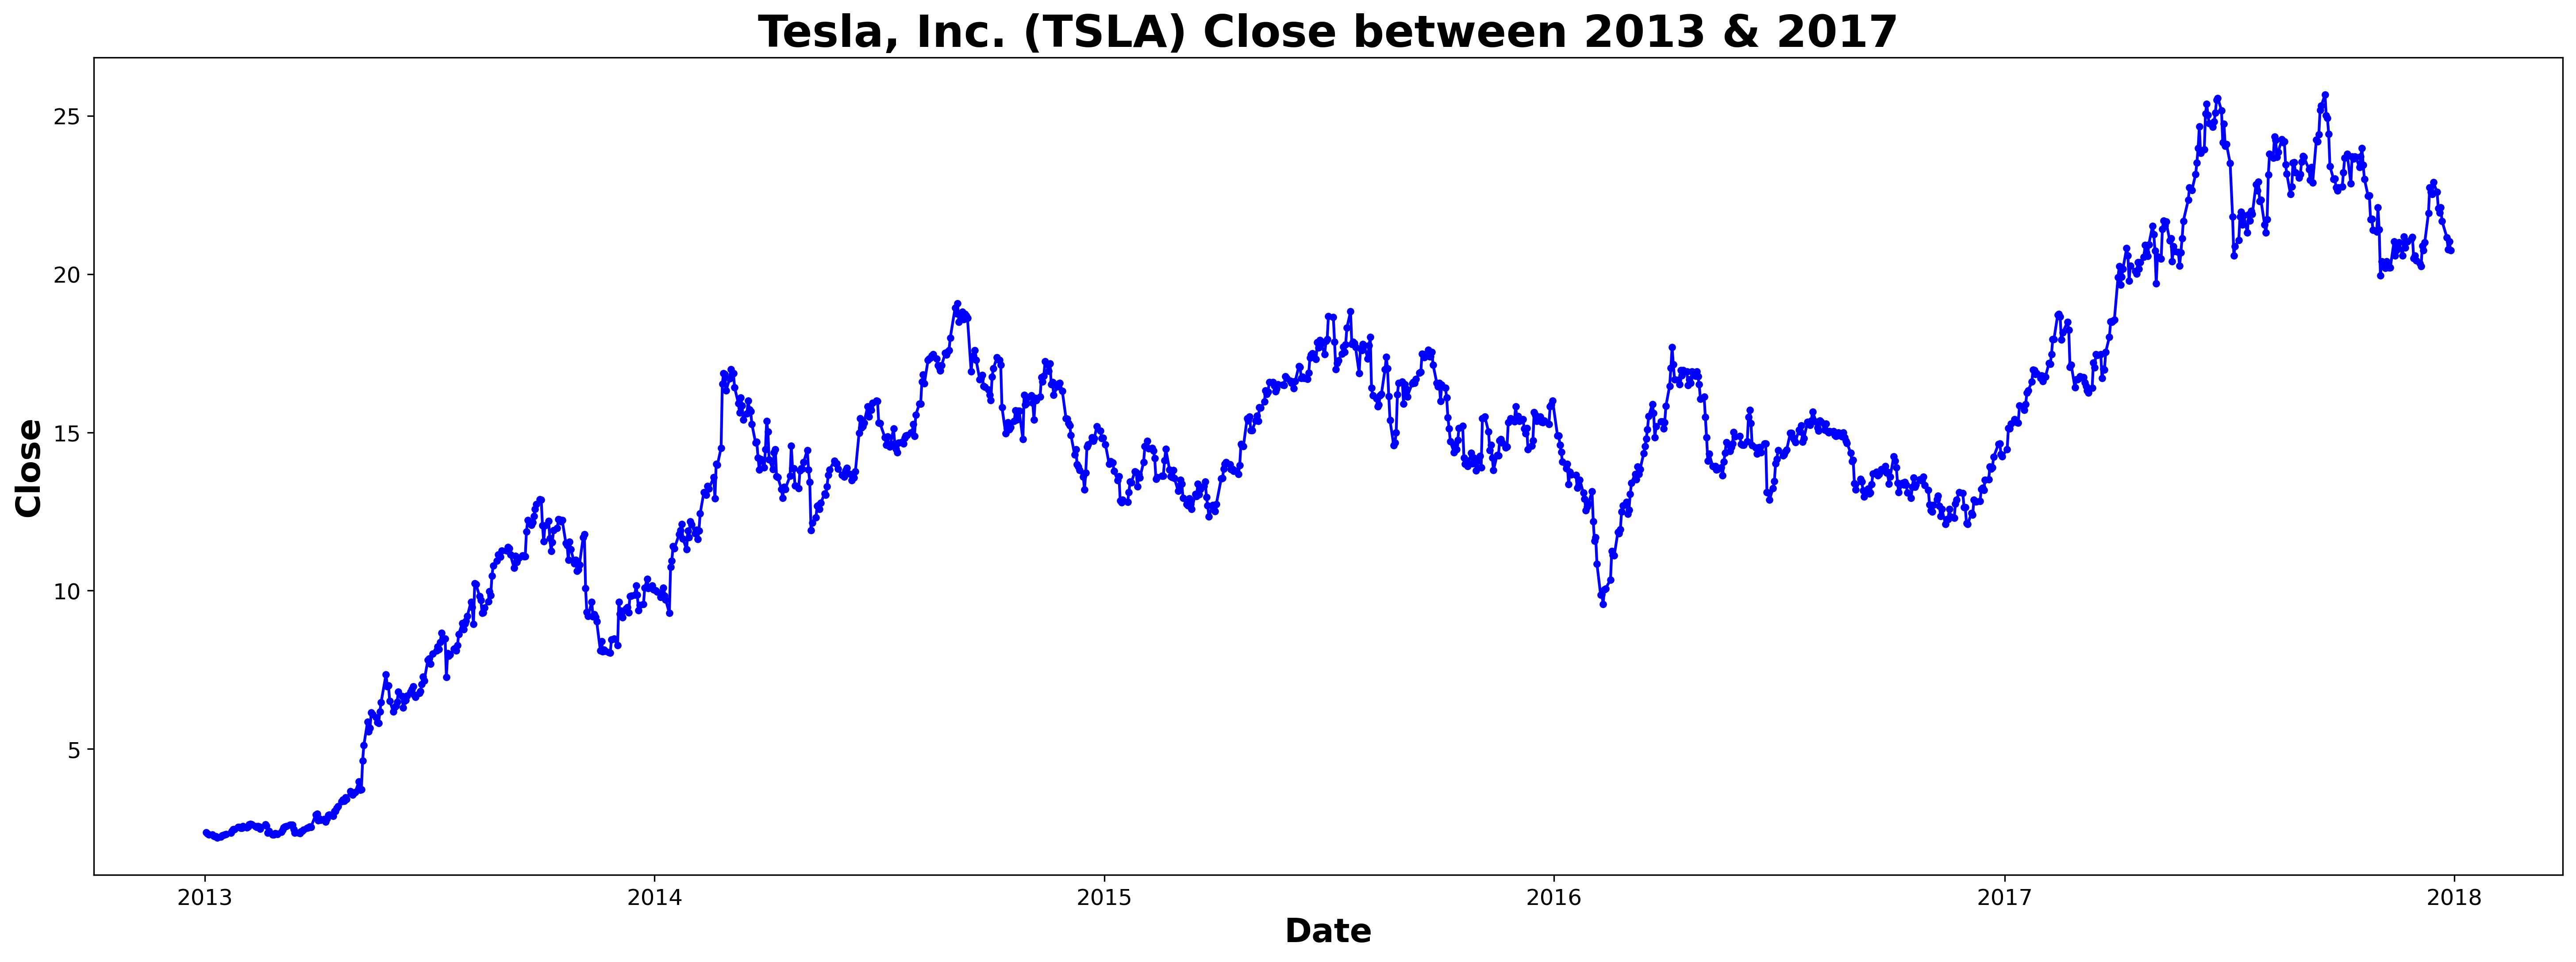

In [9]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(24,8),dpi=300)
plt.title('Tesla, Inc. (TSLA) Close between 2013 & 2017',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('Close',fontsize=18,weight='bold')

# Actual by predicted plot
plt.plot(new_df['Date'],new_df['Y'],marker='.',color='blue')

# Set the axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# 2. Creating time lags as predictor variables

# Important!: Be caution when dealing with time-series data

python do have various packages and function that can deal with time-series data with ease, however, make sure that you understand the fundamental first!

In [10]:
# Create 3 lags
new_df['Lag_1']=new_df['Y'].shift(1).copy()
new_df['Lag_2']=new_df['Y'].shift(2).copy()
new_df['Lag_3']=new_df['Y'].shift(3).copy()
new_df.head()

C:\Users\a9536\AppData\Local\Temp\ipykernel_29356\2612970619.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Lag_1']=new_df['Y'].shift(1).copy()
C:\Users\a9536\AppData\Local\Temp\ipykernel_29356\2612970619.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Lag_2']=new_df['Y'].shift(2).copy()
C:\Users\a9536\AppData\Local\Temp\ipykernel_29356\2612970619.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

,Date,Y,Lag_1,Lag_2,Lag_3
0,2013-01-02,2.357333,NaN,NaN,NaN
1,2013-01-03,2.318000,2.357333,NaN,NaN
2,2013-01-04,2.293333,2.318000,2.357333,NaN
3,2013-01-07,2.289333,2.293333,2.318000,2.357333
4,2013-01-08,2.245333,2.289333,2.293333,2.318000


In [11]:
# Drop out missing values and rest index
clean_df=new_df.dropna(axis=0, how='any').copy()
clean_df=clean_df.reset_index(drop=True)
clean_df

,Date,Y,Lag_1,Lag_2,Lag_3
0,2013-01-07,2.289333,2.293333,2.318000,2.357333
1,2013-01-08,2.245333,2.289333,2.293333,2.318000
2,2013-01-09,2.242667,2.245333,2.289333,2.293333
3,2013-01-10,2.235333,2.242667,2.245333,2.289333
4,2013-01-11,2.194000,2.235333,2.242667,2.245333
...,...,...,...,...,...
1251,2017-12-22,21.680000,22.110666,21.931999,22.073334
1252,2017-12-26,21.152666,21.680000,22.110666,21.931999
1253,2017-12-27,20.775999,21.152666,21.680000,22.110666
1254,2017-12-28,21.024000,20.775999,21.152666,21.680000


In [803]:
# Export the data
clean_df.to_csv('TSLA_Lags.csv',index=False, header=True)
# Colab
#clean_df.to_csv('Rainfall_Lags.csv',index=False, header=True)

# 3. Data preprocessing under time-series structure

A total of 21 years are in the data set. In this practice, we will use the last three years of data as the testing set

In [12]:
# Train data
Forecast_train_data=clean_df.iloc[0:1077,:].copy()
Forecast_train_data

,Date,Y,Lag_1,Lag_2,Lag_3
0,2013-01-07,2.289333,2.293333,2.318000,2.357333
1,2013-01-08,2.245333,2.289333,2.293333,2.318000
2,2013-01-09,2.242667,2.245333,2.289333,2.293333
3,2013-01-10,2.235333,2.242667,2.245333,2.289333
4,2013-01-11,2.194000,2.235333,2.242667,2.245333
...,...,...,...,...,...
1072,2017-04-10,20.826000,20.169333,19.913334,19.666668
1073,2017-04-11,20.580667,20.826000,20.169333,19.913334
1074,2017-04-12,19.789333,20.580667,20.826000,20.169333
1075,2017-04-13,20.266666,19.789333,20.580667,20.826000


In [13]:
# Test data
Forecast_test_data=clean_df.iloc[1077:,:].copy()
Forecast_test_data

,Date,Y,Lag_1,Lag_2,Lag_3
1077,2017-04-18,20.016666,20.096001,20.266666,19.789333
1078,2017-04-19,20.368000,20.016666,20.096001,20.266666
1079,2017-04-20,20.167334,20.368000,20.016666,20.096001
1080,2017-04-21,20.373333,20.167334,20.368000,20.016666
1081,2017-04-24,20.535334,20.373333,20.167334,20.368000
...,...,...,...,...,...
1251,2017-12-22,21.680000,22.110666,21.931999,22.073334
1252,2017-12-26,21.152666,21.680000,22.110666,21.931999
1253,2017-12-27,20.775999,21.152666,21.680000,22.110666
1254,2017-12-28,21.024000,20.775999,21.152666,21.680000


# 4. Prepare time-series data for train/validation structure manually

Here we have a total of 18 years of data in training data set that are ready to be further splitted into training and validation data set

18 years of data can be evenlly divided into 6 portions (3 years in each portion)

# Rolling window

In [14]:
# Rolling 1
Rol_training_1=Forecast_train_data.iloc[0:537,:].copy()
Rol_val_1=Forecast_train_data.iloc[537:537+180,:].copy()

# Rolling 2
Rol_training_2=Forecast_train_data.iloc[177:717,:].copy()
Rol_val_2=Forecast_train_data.iloc[717:171+180,:].copy()

# Rolling 3
Rol_training_3=Forecast_train_data.iloc[357:897,:].copy()
Rol_val_3=Forecast_train_data.iloc[897:897+180,:].copy()

# 5. Set dependent variable(Y or target) & independent variable(X)

In [15]:
#set x (make prediction)
# Train
x_train=Rol_training_1.drop(['Date','Y'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingT=MMscaler.fit_transform(x_train)
scaled_x_train=pd.DataFrame(data=scalingT)
scaled_x_train.columns=['Lag_1','Lag_2','Lag_3']


# Validation
x_val=Rol_val_1.drop(['Date','Y'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingV=MMscaler.fit_transform(x_val)
scaled_x_val=pd.DataFrame(data=scalingV)
scaled_x_val.columns=['Lag_1','Lag_2','Lag_3']


#set y (want to predict)
y_train=Rol_training_1['Y'].copy()
y_val=Rol_val_1['Y'].copy()

# 6. Creating Net

In [16]:
# Quick recap: Total of 12 features in the data set
scaled_x_train.head()

,Lag_1,Lag_2,Lag_3
0,0.005886,0.007348,0.009679
1,0.005649,0.005886,0.007348
2,0.003042,0.005649,0.005886
3,0.002884,0.003042,0.005649
4,0.002449,0.002884,0.003042


In [17]:
# Tips: Using shape to call the amount of features in the data set
input_features=scaled_x_train.shape[1]
print('Amount of features:',input_features)

Amount of features: 3


# Important: Define customized loss function (RMSE)

In [18]:
from keras.losses import mse
from keras.backend import sqrt

def my_RMSE(y_true, y_pred):
    return sqrt(mse(y_true, y_pred))

# Register custom object
#from keras.utils.generic_utils import get_custom_objects for pc
from keras.utils.generic_utils import get_custom_objects
# from tensorflow.keras.saving import get_custom_objects
get_custom_objects().update({'my_RMSE': my_RMSE})

Note: As far as I know when I'm preparing this in-class material, keras does not have a built-in RMSE function. Rumor has it that a RMSE function is hidden in the latest version, however it needs to be confirmed. For instance, defining RMSE ourself is not difficult, just don't forget to register our custom functions.

# Sequential style coding for creating net

In [811]:
# 十層
clear.clear_session()

model = Sequential()

model.add(Dense(units=6, input_dim=3, activation='relu'))

model.add(Dense(units=12, activation='relu'))

model.add(Dense(units=24, activation='relu'))

model.add(Dense(units=48, activation='relu'))

model.add(Dense(units=96, activation='relu'))

model.add(Dense(units=192, activation='relu'))

model.add(Dense(units=192*2, activation='relu'))

model.add(Dense(units=192*4, activation='relu'))

model.add(Dense(units=192*8, activation='relu'))

model.add(Dropout(0.3))

model.add(Dense(units=192*2, activation='relu'))

model.add(Dense(units=1, activation='linear'))


opt = Adam(learning_rate=0.000006, beta_1=0.95)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 24        
                                                                 
 dense_1 (Dense)             (None, 12)                84        
                                                                 
 dense_2 (Dense)             (None, 24)                312       
                                                                 
 dense_3 (Dense)             (None, 48)                1200      
                                                                 
 dense_4 (Dense)             (None, 96)                4704      
                                                                 
 dense_5 (Dense)             (None, 192)               18624     
                                                                 
 dense_6 (Dense)             (None, 384)               7

In [81]:
# 十一層
clear.clear_session()

model = Sequential()

model.add(Dense(units=6, input_dim=3, activation='relu'))

model.add(Dense(units=12, activation='relu'))

model.add(Dense(units=24, activation='relu'))

model.add(Dense(units=48, activation='relu'))

model.add(Dense(units=96, activation='relu'))

model.add(Dense(units=192, activation='relu'))

model.add(Dense(units=192*2, activation='relu'))

model.add(Dense(units=192*4, activation='relu'))

model.add(Dense(units=192*4, activation='relu'))

model.add(Dense(units=192*4, activation='relu'))


model.add(Dense(units=192, activation='relu'))


model.add(Dense(units=1, activation='linear'))


opt = Adam(learning_rate=0.000005, beta_1=0.95)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 24        
                                                                 
 dense_1 (Dense)             (None, 12)                84        
                                                                 
 dense_2 (Dense)             (None, 24)                312       
                                                                 
 dense_3 (Dense)             (None, 48)                1200      
                                                                 
 dense_4 (Dense)             (None, 96)                4704      
                                                                 
 dense_5 (Dense)             (None, 192)               18624     
                                                                 
 dense_6 (Dense)             (None, 384)               7

In [75]:
# 十二層
clear.clear_session()

model = Sequential()

model.add(Dense(units=6, input_dim=3, activation='relu'))

model.add(Dense(units=12, activation='relu'))

model.add(Dense(units=24, activation='relu'))

model.add(Dense(units=48, activation='relu'))

model.add(Dense(units=96, activation='relu'))

model.add(Dense(units=192, activation='relu'))

model.add(Dense(units=192*2, activation='relu'))

model.add(Dense(units=192*4, activation='relu'))

model.add(Dense(units=192*4, activation='relu'))

model.add(Dense(units=192*2, activation='relu'))

model.add(Dense(units=192*2, activation='relu'))

model.add(Dense(units=192, activation='relu'))


model.add(Dense(units=1, activation='linear'))


opt = Adam(learning_rate=0.000006, beta_1=0.93)

model.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 24        
                                                                 
 dense_1 (Dense)             (None, 12)                84        
                                                                 
 dense_2 (Dense)             (None, 24)                312       
                                                                 
 dense_3 (Dense)             (None, 48)                1200      
                                                                 
 dense_4 (Dense)             (None, 96)                4704      
                                                                 
 dense_5 (Dense)             (None, 192)               18624     
                                                                 
 dense_6 (Dense)             (None, 384)               7

Note: Remember to clear the session or else some of the left neurans may cause trouble while fitting

# 7. Fit the model (train/validation)

In [82]:
# 7.1 Store in the history for more useful information
history=model.fit(scaled_x_train, y_train, epochs=100, batch_size=64,verbose=1,validation_data=(scaled_x_val, y_val))

Epoch 1/100
9/9 [==============================] - 1s 34ms/step - loss: 11.1526 - mean_absolute_percentage_error: 99.8954 - val_loss: 15.6780 - val_mean_absolute_percentage_error: 99.8899
Epoch 2/100
9/9 [==============================] - 0s 13ms/step - loss: 11.1434 - mean_absolute_percentage_error: 99.8145 - val_loss: 15.6693 - val_mean_absolute_percentage_error: 99.8362
Epoch 3/100
9/9 [==============================] - 0s 14ms/step - loss: 11.1345 - mean_absolute_percentage_error: 99.7380 - val_loss: 15.6607 - val_mean_absolute_percentage_error: 99.7833
Epoch 4/100
9/9 [==============================] - 0s 14ms/step - loss: 11.1258 - mean_absolute_percentage_error: 99.6621 - val_loss: 15.6522 - val_mean_absolute_percentage_error: 99.7311
Epoch 5/100
9/9 [==============================] - 0s 12ms/step - loss: 11.1172 - mean_absolute_percentage_error: 99.5856 - val_loss: 15.6437 - val_mean_absolute_percentage_error: 99.6785
Epoch 6/100
9/9 [==============================] - 0s 14ms/s

In [83]:
# Check the dictionary keys
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'mean_absolute_percentage_error', 'val_loss', 'val_mean_absolute_percentage_error'])

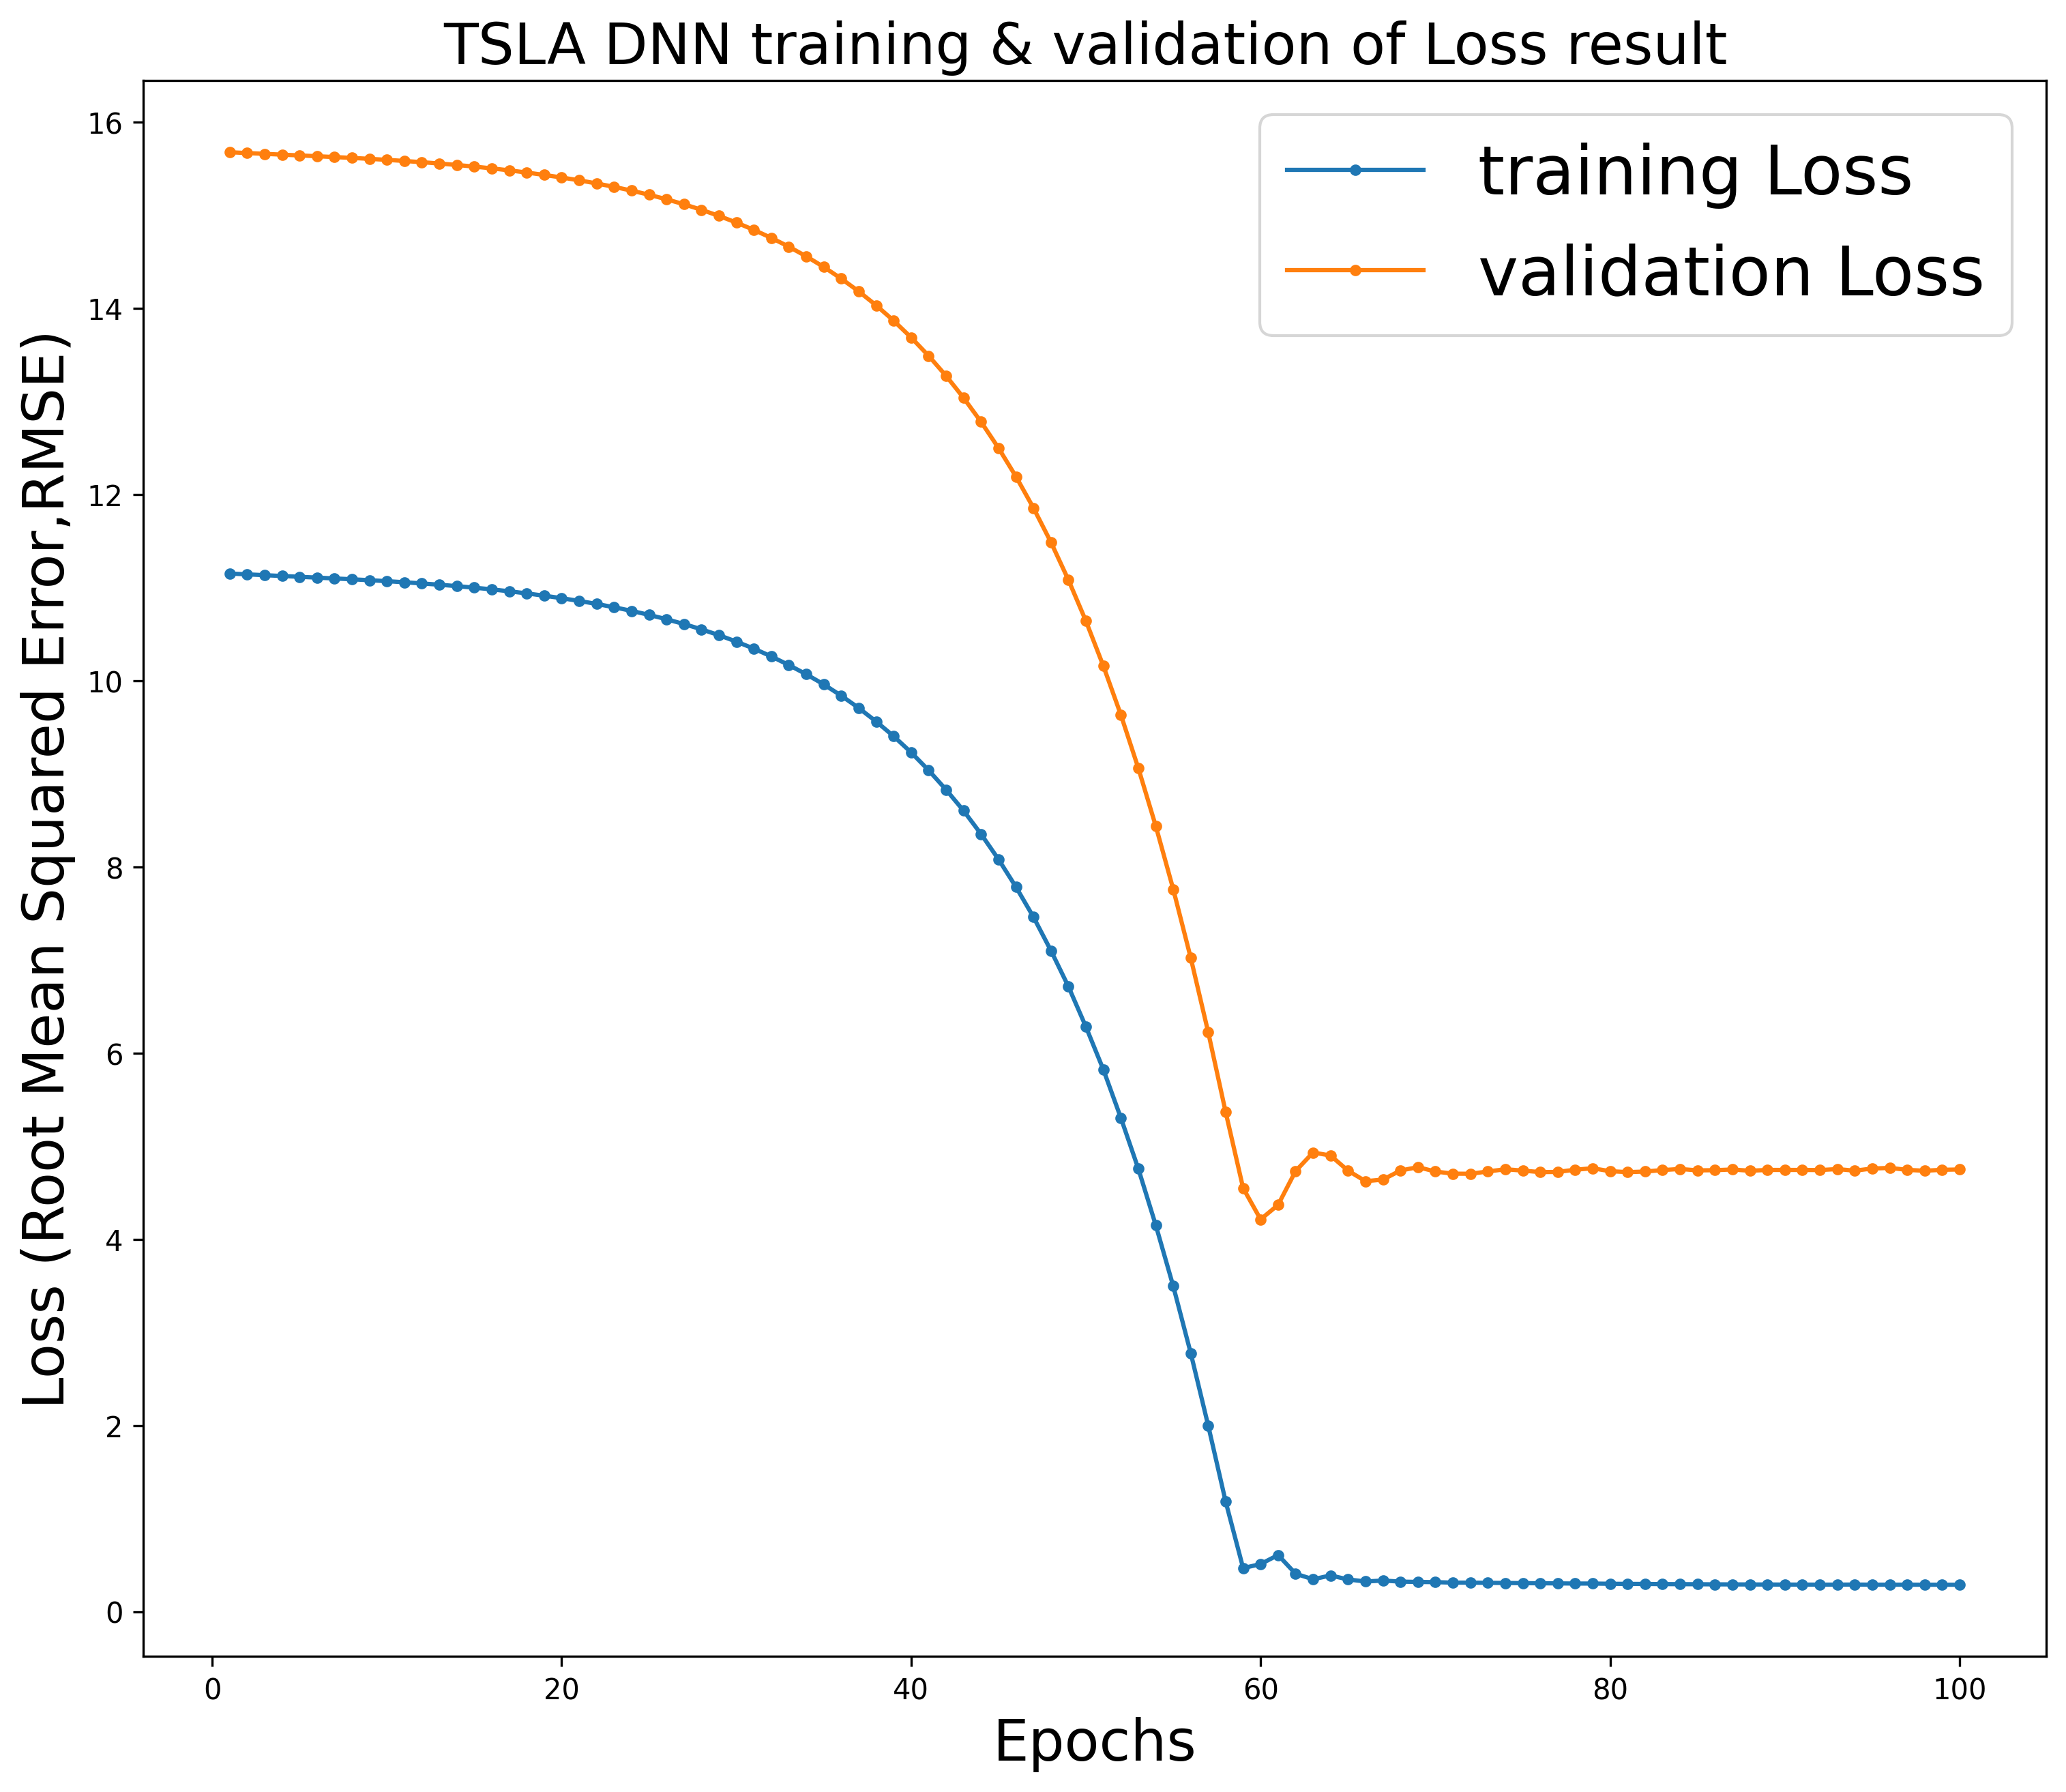

In [84]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Root Mean Squared Error,RMSE)',fontsize=20)
plt.title('TSLA DNN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='.',label='training Loss')
plt.plot(epochs, val_loss_values,marker='.',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

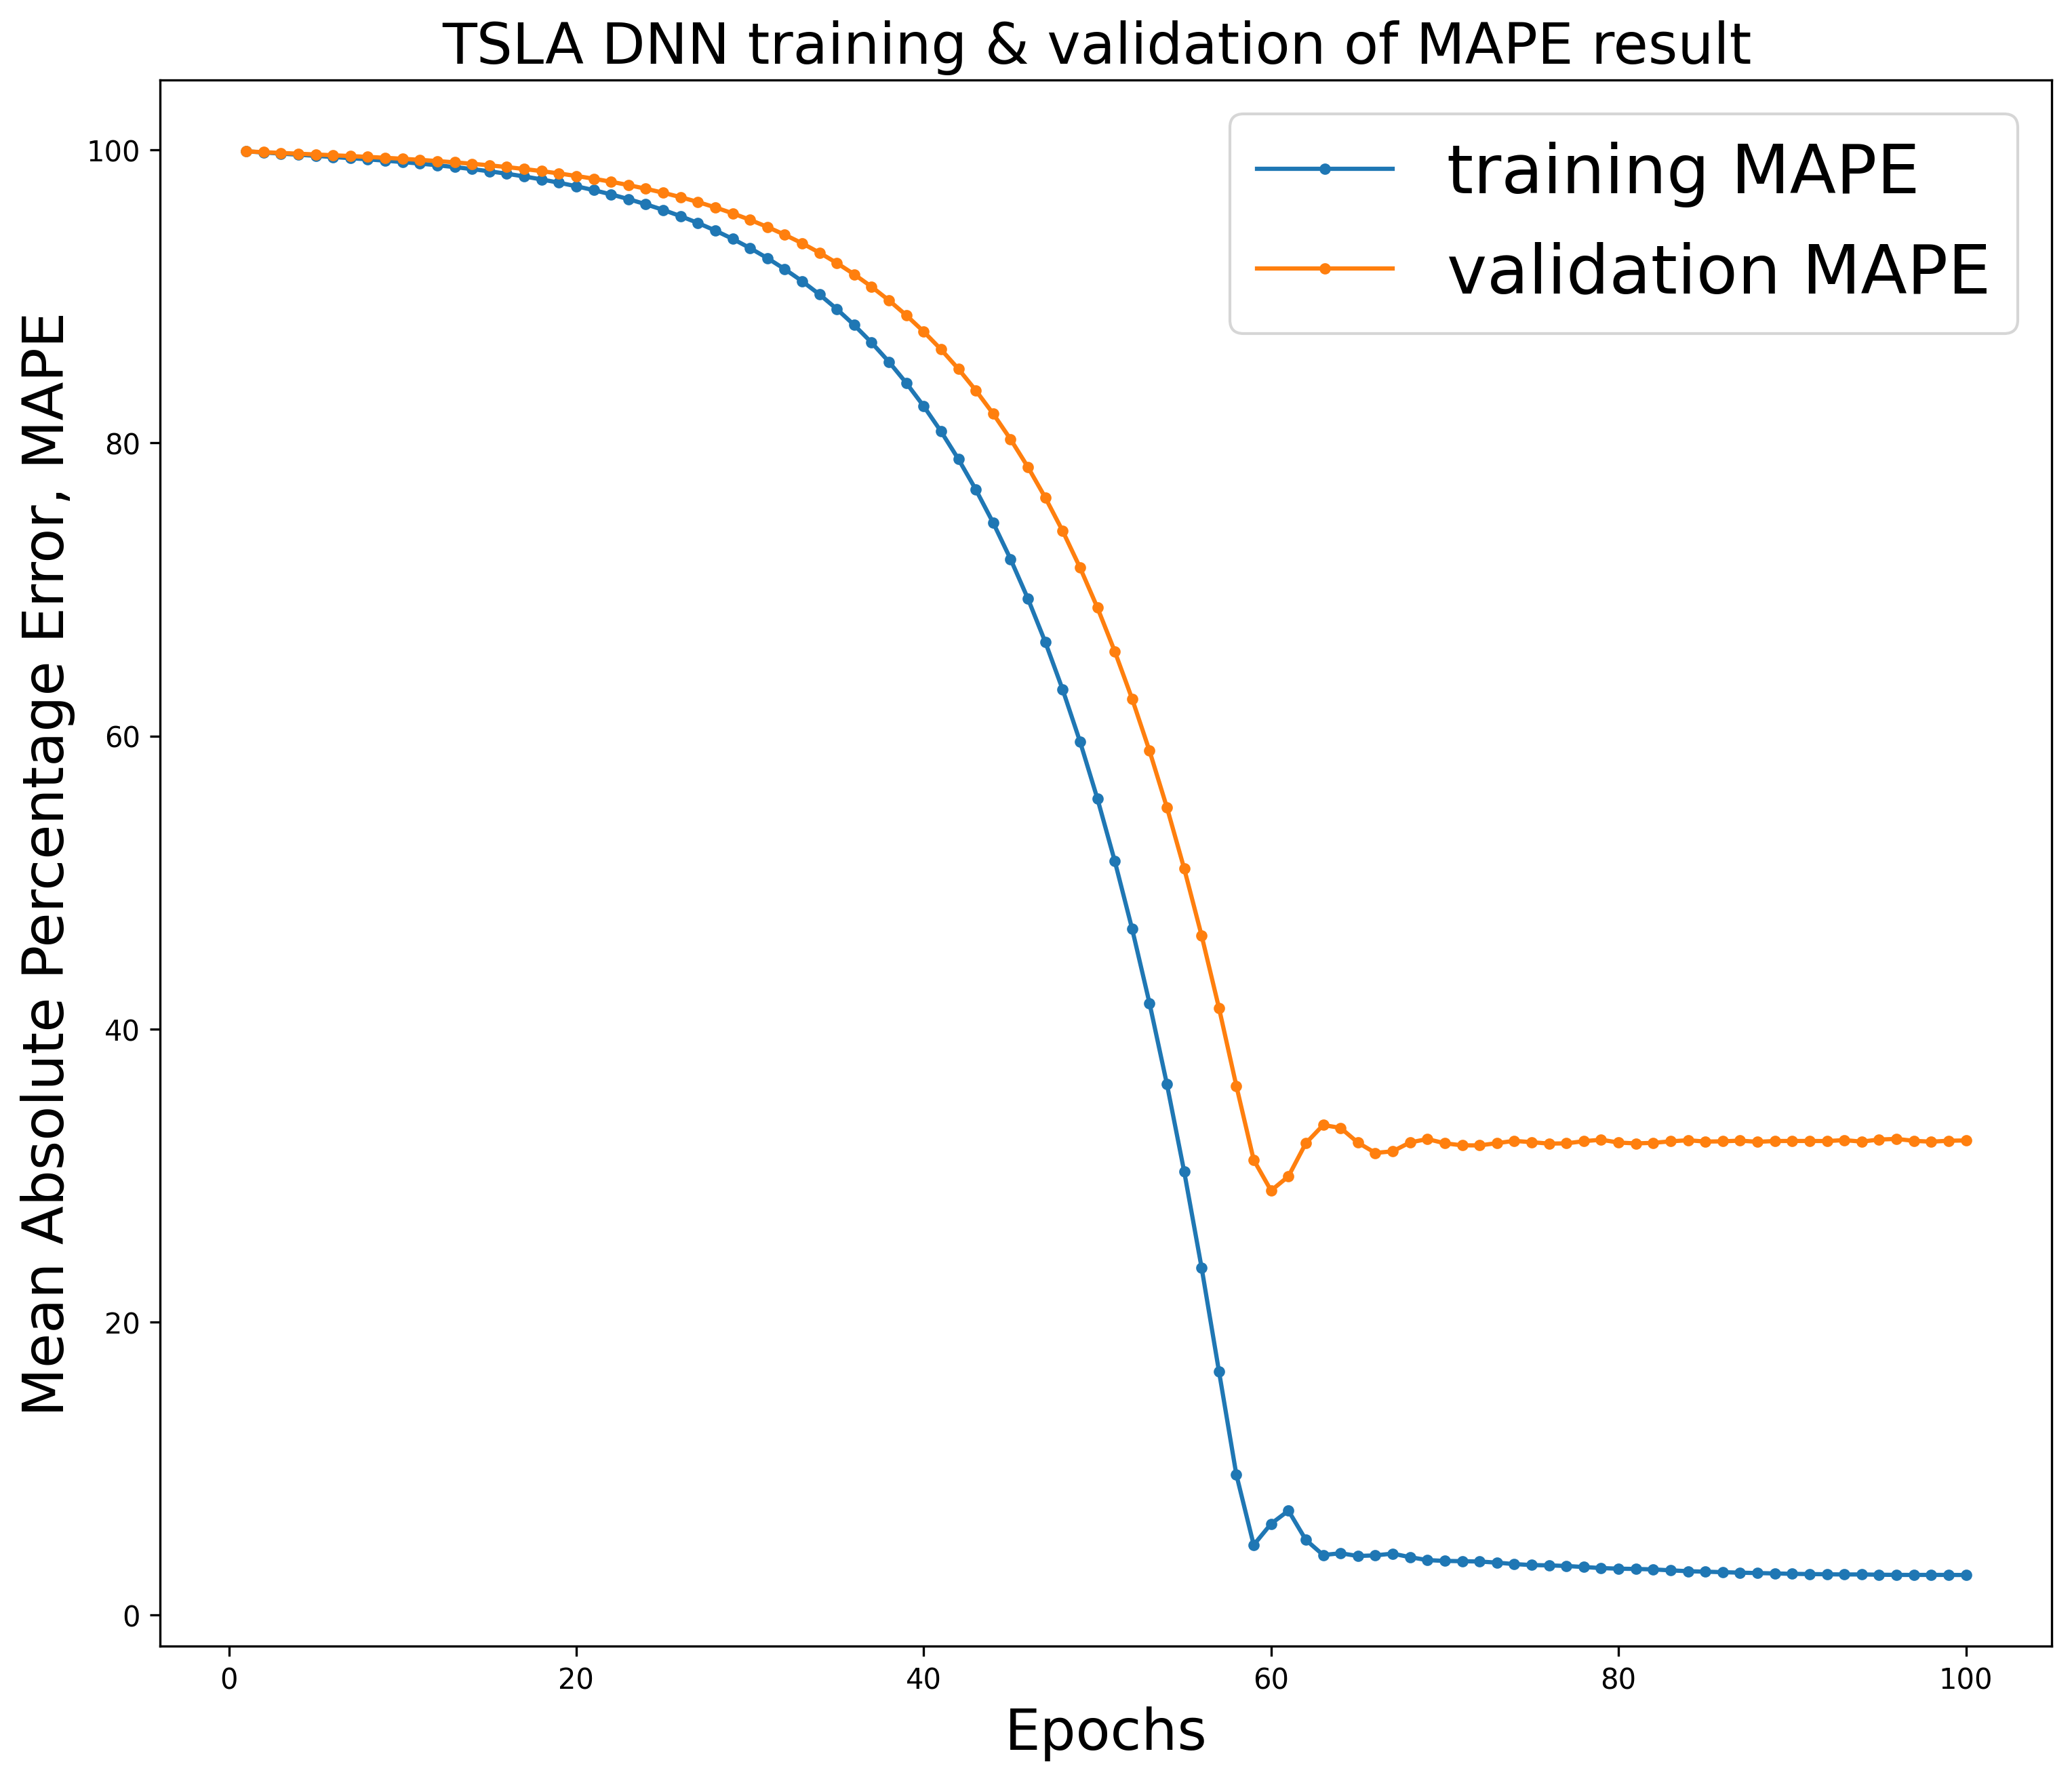

In [85]:
# 7.2 Plot the history of training and validation
training_acc_values=modeling_result['mean_absolute_percentage_error']
val_acc_values=modeling_result['val_mean_absolute_percentage_error']
epochs=range(1,len(training_acc_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Mean Absolute Percentage Error, MAPE',fontsize=20)
plt.title('TSLA DNN training & validation of MAPE result ',fontsize=20)

plt.plot(epochs, training_acc_values,marker='.',label='training MAPE')
plt.plot(epochs, val_acc_values,marker='.',label='validation MAPE')
plt.legend(loc=1,fontsize=24)
plt.show()

# Fit the final model with all of the training data

In [46]:
# X all train data
x_forecast_train=Forecast_train_data.drop(['Date','Y'],axis=1).copy()
# Y all train data
y_forecast_train=Forecast_train_data['Y'].copy()

In [47]:
clear.clear_session()

Fmodel = Sequential()

Fmodel.add(Dense(units=6, input_dim=3, activation='relu'))

Fmodel.add(Dense(units=12, activation='relu'))

Fmodel.add(Dense(units=24, activation='relu'))

Fmodel.add(Dense(units=48, activation='relu'))

Fmodel.add(Dense(units=96, activation='relu'))

Fmodel.add(Dense(units=192, activation='relu'))

Fmodel.add(Dense(units=192*2, activation='relu'))

Fmodel.add(Dense(units=192*4, activation='relu'))

Fmodel.add(Dense(units=192*4, activation='relu'))

Fmodel.add(Dense(units=192*4, activation='relu'))

Fmodel.add(Dense(units=192, activation='relu'))

Fmodel.add(Dense(units=1, activation='linear'))

opt = Adam(learning_rate=0.000005, beta_1=0.95)
Fmodel.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])


Fmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 24        
                                                                 
 dense_1 (Dense)             (None, 12)                84        
                                                                 
 dense_2 (Dense)             (None, 24)                312       
                                                                 
 dense_3 (Dense)             (None, 48)                1200      
                                                                 
 dense_4 (Dense)             (None, 96)                4704      
                                                                 
 dense_5 (Dense)             (None, 192)               18624     
                                                                 
 dense_6 (Dense)             (None, 384)               7

In [48]:
# Store in the history for more useful information
history=Fmodel.fit(x_forecast_train, y_forecast_train, epochs=100, batch_size=64,verbose=1)

Epoch 1/100
17/17 [==============================] - 1s 19ms/step - loss: 13.1139 - mean_absolute_percentage_error: 99.8936
Epoch 2/100
17/17 [==============================] - 0s 14ms/step - loss: 12.9970 - mean_absolute_percentage_error: 99.0007
Epoch 3/100
17/17 [==============================] - 0s 13ms/step - loss: 12.8966 - mean_absolute_percentage_error: 98.2318
Epoch 4/100
17/17 [==============================] - 0s 12ms/step - loss: 12.7961 - mean_absolute_percentage_error: 97.4599
Epoch 5/100
17/17 [==============================] - 0s 13ms/step - loss: 12.6879 - mean_absolute_percentage_error: 96.6312
Epoch 6/100
17/17 [==============================] - 0s 15ms/step - loss: 12.5694 - mean_absolute_percentage_error: 95.7214
Epoch 7/100
17/17 [==============================] - 0s 13ms/step - loss: 12.4352 - mean_absolute_percentage_error: 94.6974
Epoch 8/100
17/17 [==============================] - 0s 13ms/step - loss: 12.2845 - mean_absolute_percentage_error: 93.5366
Epoch 9/

In [49]:
# 7.3 Save the trained model
#Fmodel.save('D:/data_analysis/PyExport/Rainfall_forecast_ANN_trained_model.h5')
# Colab
Fmodel.save('Forecast_RollingWindow_DNN_trained_model.h5')
print('Model has been saved...')

Model has been saved...


In [58]:
# 7.4 Restore the saved model for testing
#ANN_model=keras.models.load_model('D:/data_analysis/PyExport/Rainfall_forecast_ANN_trained_model.h5')
# Colab
DNN_model=keras.models.load_model('Forecast_RollingWindow_DNN_trained_model.h5')
print('Model successfully loaded...')

Model successfully loaded...


# 8. Testing

In [59]:
# X test
x_forecast_test=Forecast_test_data.drop(['Date','Y'],axis=1).copy()
# Y test
y_forecast_test=Forecast_test_data['Y'].copy()

In [60]:
# 8.1 Make prediction
prediction=np.round((DNN_model.predict_on_batch(x_forecast_test)),2)
pred_values=[]
for i in range(0,len(prediction)):
    value=prediction[i][0]
    pred_values.append(value)

In [61]:
Results=pd.DataFrame({'Date':Forecast_test_data['Date'],'Y_true':Forecast_test_data['Y'],'Predict':pred_values})
Results['abs Error']=np.abs(Results['Y_true']-Results['Predict'])
Results

,Date,Y_true,Predict,abs Error
1077,2017-04-18,20.016666,20.070000,0.053334
1078,2017-04-19,20.368000,20.010000,0.358000
1079,2017-04-20,20.167334,20.190001,0.022667
1080,2017-04-21,20.373333,20.170000,0.203333
1081,2017-04-24,20.535334,20.260000,0.275334
...,...,...,...,...
1251,2017-12-22,21.680000,21.980000,0.300000
1252,2017-12-26,21.152666,21.770000,0.617334
1253,2017-12-27,20.775999,21.330000,0.554001
1254,2017-12-28,21.024000,20.900000,0.124000


In [65]:
# 8.2 Calculating the mertics
MAE=mean_absolute_error(y_forecast_test,pred_values)
MSE=mean_squared_error(y_forecast_test,pred_values,squared=True)
RMSE=mean_squared_error(y_forecast_test,pred_values,squared=False)
# MAPE=mean_absolute_percentage_error(y_forecast_test,pred_values)
SMAPE=SMAPE_calulate(y_forecast_test,pred_values)
# RAE=RAE_calculate(y_forecast_test,pred_values)
# MRAE=MRAE_calculate(y_forecast_test,pred_values)
MdRAE=MdRAE_calculate(y_forecast_test,pred_values)
# RSE=RSE_calculate(y_forecast_test,pred_values,Root=False)
# RRSE=RSE_calculate(y_forecast_test,pred_values,Root=True)

print('MAE:',round(MAE,3))
print('MSE:',round(MSE,3))
print('RMSE:',round(RMSE,3))
# print('MAPE:',round(MAPE*100,3),'%')
print('SMAPE:',round(SMAPE,3),'%')
# print('RAE:',round(RAE,3))
# print('MRAE:',MRAE)
print('MdRAE:',round(MdRAE[0],3),'bench:',round(MdRAE[1],3))
# print('RSE:',round(RSE,3))
# print('RRSE:',round(RRSE,3))

MAE: 0.421
MSE: 0.306
RMSE: 0.553
SMAPE: 1.876 %
MdRAE: 0.29 bench: 22.397


#  Plot for comparing true value & predicted value

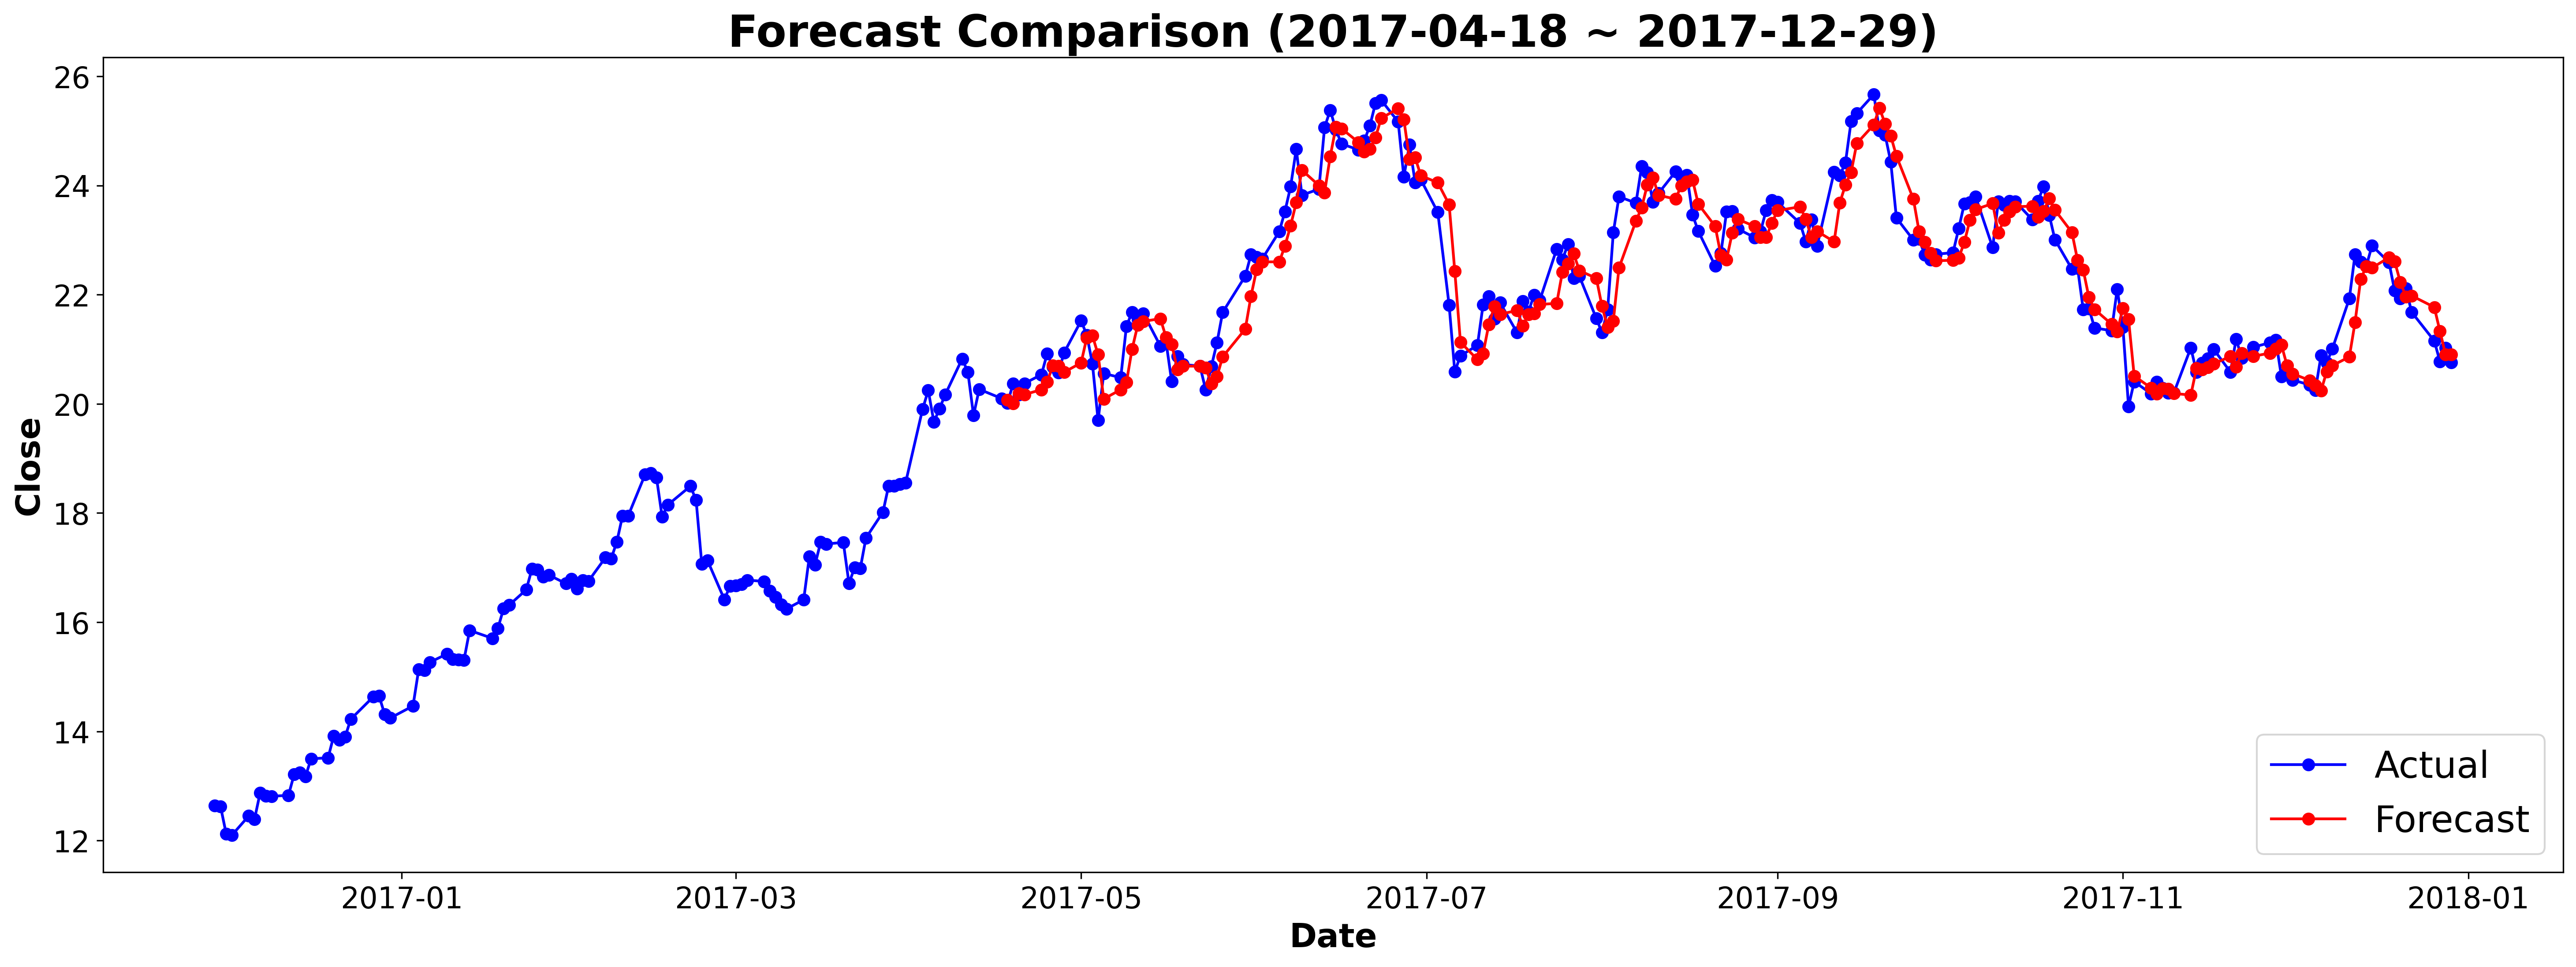

In [66]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(24,8),dpi=300)
plt.title('Forecast Comparison (2017-04-18 ~ 2017-12-29)',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('Close',fontsize=18,weight='bold')

# Comparison of actual value and predicted value according to Date
plt.plot(clean_df.iloc[982:,0],clean_df.iloc[982:,1],marker='o',color='blue',label='Actual')
plt.plot(Results['Date'],Results['Predict'],marker='o',color='red',label='Forecast')

# Set the axis
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Set legends
plt.legend(loc=4,fontsize=20)

plt.show()

# Actual by predicted plot

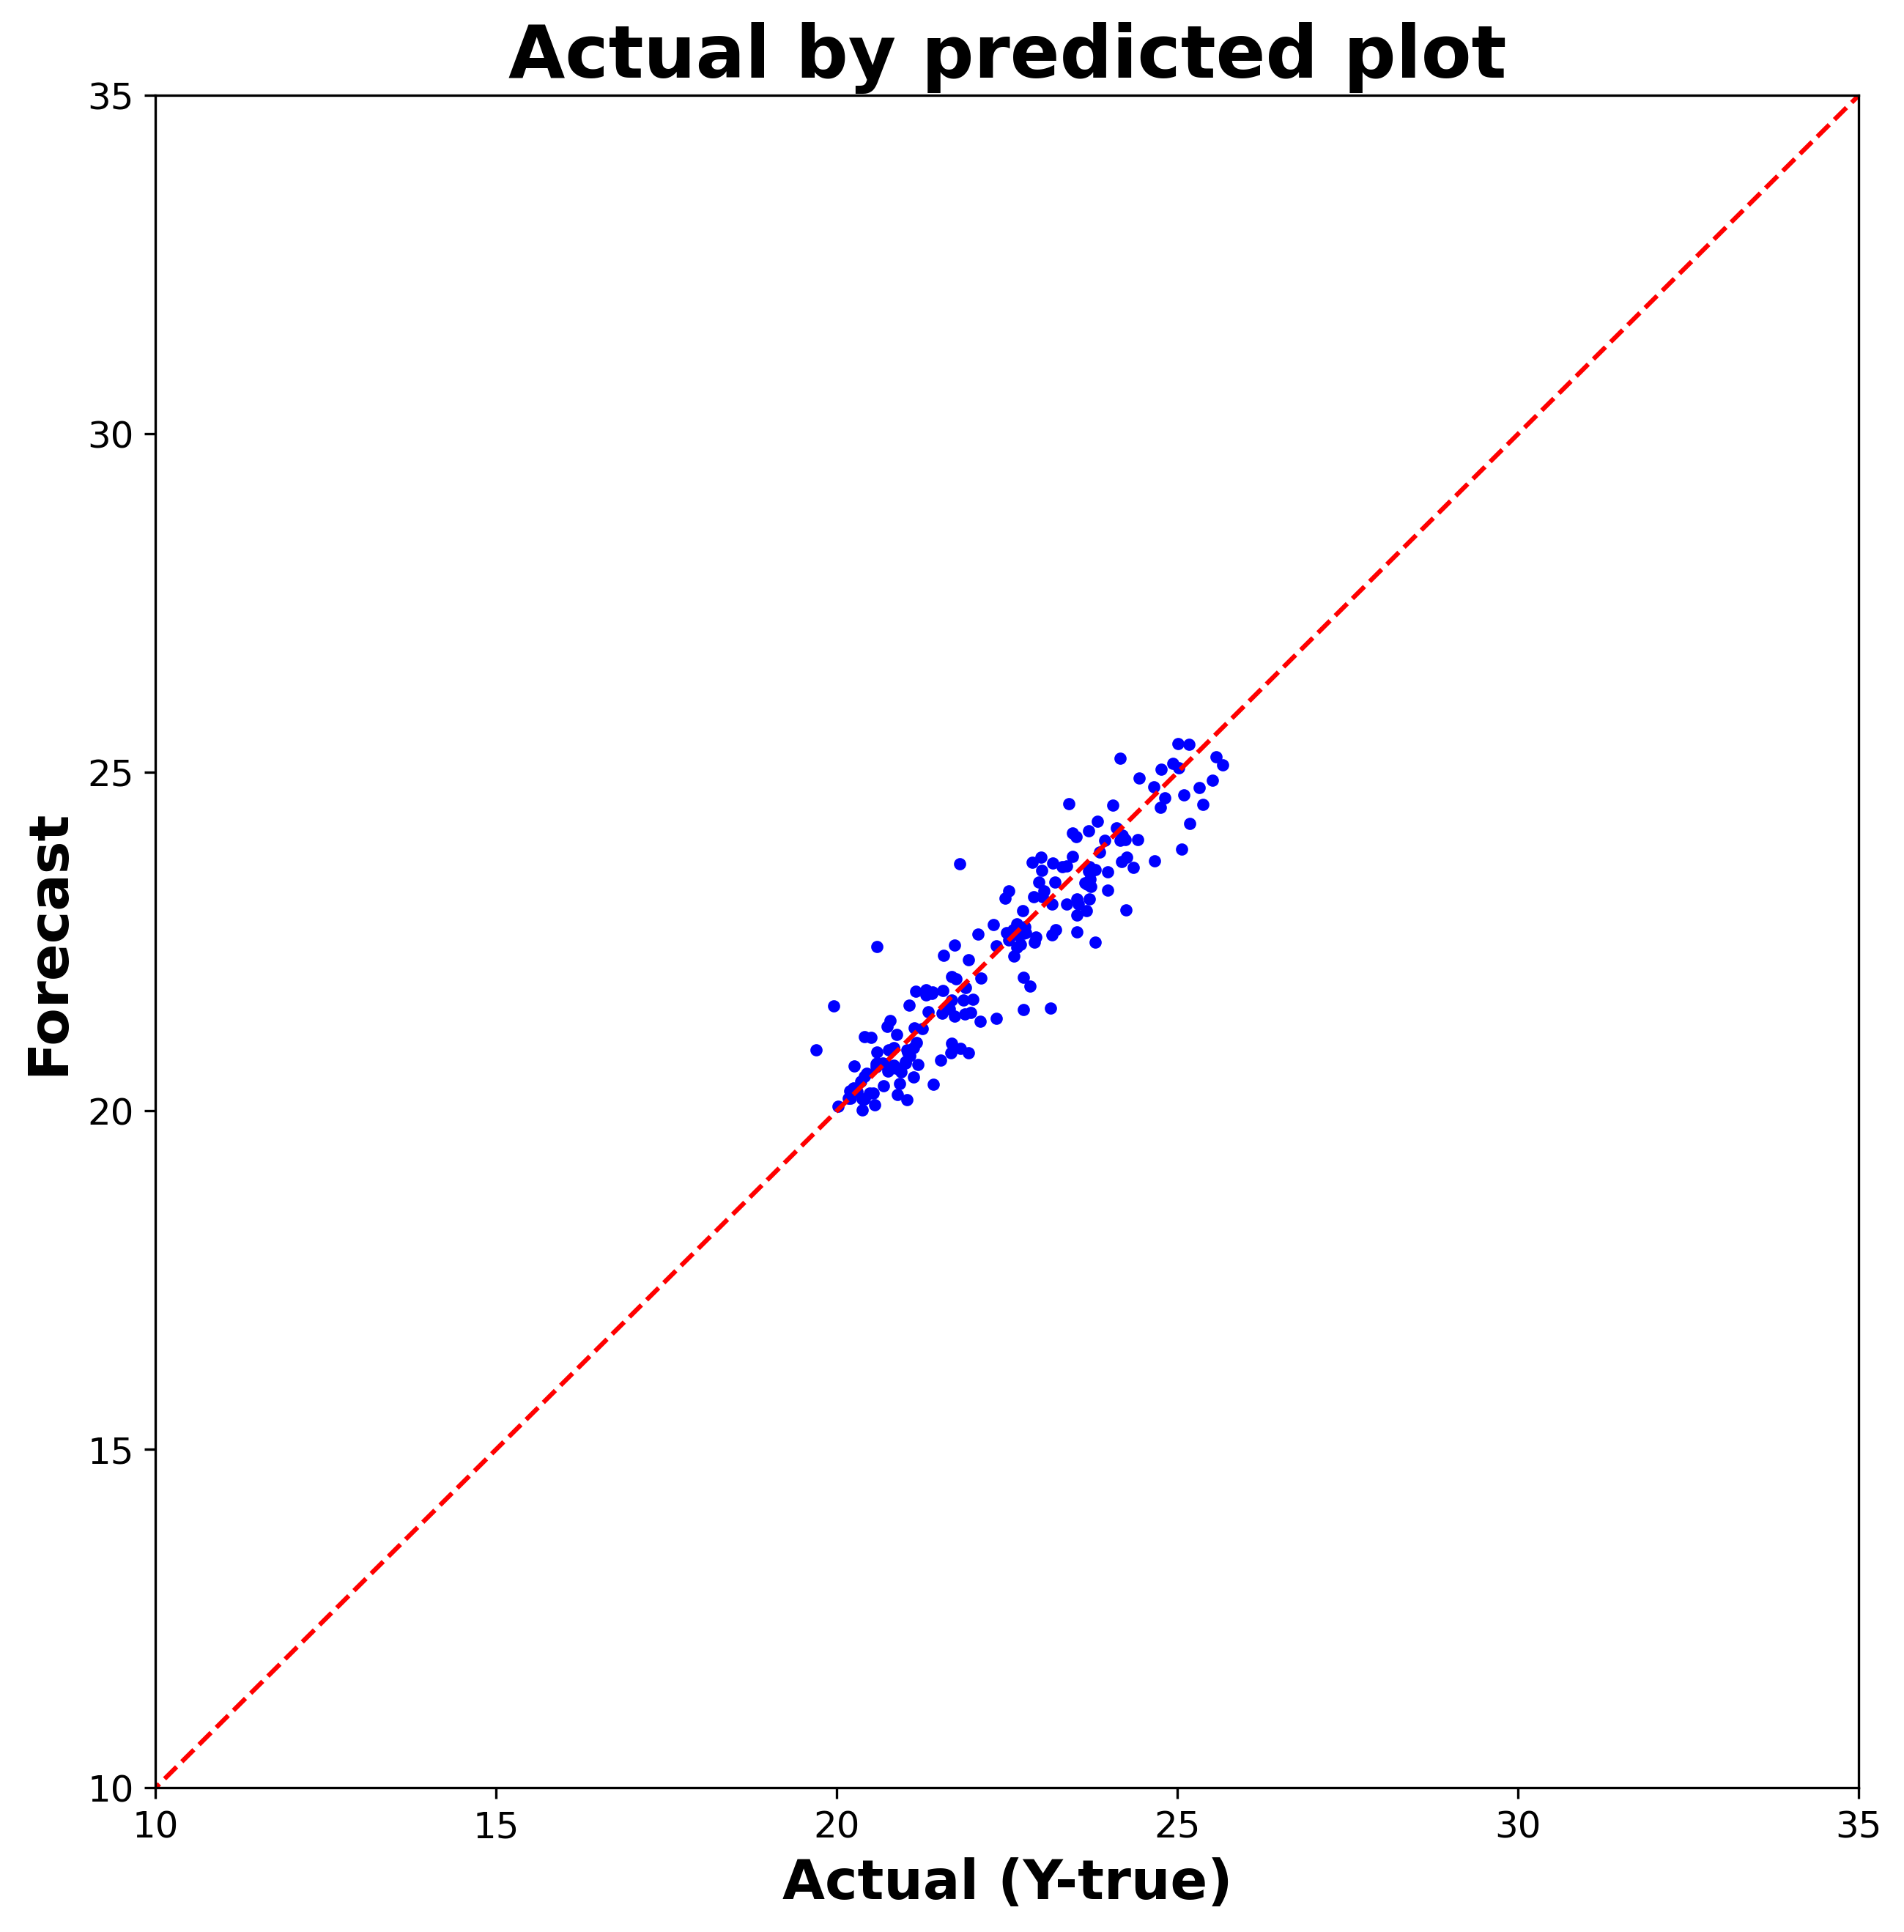

In [67]:
# Lock the scale of axis by Y_true
# max_value=100+5
# min_value=0-5
max_value=35
min_value=0

# Figure setting
plt.figure(figsize=(10,10),dpi=300)
plt.title('Actual by predicted plot',weight='bold',fontsize=24)
plt.xlabel('Actual (Y-true)',fontsize=18,weight='bold')
plt.ylabel('Forecast',fontsize=18,weight='bold')

# Perfect model reference line
plt.plot([min_value,max_value], [min_value,max_value], linestyle='--',color='red')

# Actual by predicted plot
plt.scatter(Results.iloc[:,1],Results.iloc[:,2],marker='.',color='blue')

# Set the axis
plt.ylim(10,max_value)
plt.xlim(10,max_value)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()